In [101]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from scipy.spatial.distance import cdist

In [102]:
def calculate_average(*args,**kwargs):
    return np.mean(args)

In [103]:
def calculate_cost(data: np.ndarray) -> np.ndarray:
    costs = cdist(data[:,2].reshape(-1,1), data[:,2].reshape(-1,1),calculate_average)
    distances = np.round(cdist(data[:,:2], data[:,:2], 'euclidean'))
    distances = distances + costs
    return distances

In [104]:
def get_match_node(edge1: list, edge2: list) -> list:
    intersection = set(edge1).intersection(set( edge2))
    return list(intersection)

In [105]:
def sort_edges(edges: list) -> list:
    edges_sorted = [edges.pop(0)]
    last_edge = edges_sorted[-1]
    number_of_edges = len(edges)
    while len(edges_sorted) != number_of_edges:
        index = 0
        while len(edges) > index:
            matching_node = get_match_node(last_edge, edges[index])
            if matching_node:
                matching_node = matching_node[0]
                last_edge = last_edge if matching_node == last_edge[1] else last_edge[::-1]
                edge = edges.pop(index)
                edge = edge if last_edge[1] == edge[0] else edge[::-1]
                edges_sorted[-1] = last_edge
                edges_sorted.append(edge)
                last_edge = edges_sorted[-1]
                break
            index+=1
    edges_sorted.append(edges.pop(0))
    return edges_sorted

In [106]:
def choose_node_regret_weighted(distances:np.ndarray,edges:list,available_nodes:set,weight: float = 0.5) -> tuple:
    costs = []
    edges = np.array(edges)
    k = 0 if edges.shape[0] < 2 else 1
    for node_index in available_nodes:
        node_costs = distances[node_index][edges].sum(axis=1) - distances[edges[:,0],edges[:,1]]
        indicies = node_costs.argsort()
        regret = abs(node_costs[indicies[0]] - node_costs[indicies[k]])
        regret = weight*regret + (1-weight)*node_costs[indicies[0]]
        costs.append([regret,indicies[0],node_index])
    costs = np.array(costs)
    _,edges_index,new_node_index = costs[costs[:,0].argmax()]
    new_node_index = int(new_node_index)
    cost = distances[int(new_node_index)][edges[int(edges_index)]].sum() - distances[edges[int(edges_index)][0],edges[int(edges_index)][1]]
    return cost, int(new_node_index), int(edges_index)

In [107]:
def greedy_cycle(data,node_index:int,weight:float=1):
    distances = calculate_cost(data)
    visited,edges = [],[]
    limit = len(data) // 2
    cost = data[node_index][-1]
    all_nodes = set(range(len(data)))
    value = cost
    edges.append([node_index,node_index])
    visited.append(node_index)
    while(len(visited) < limit):
        cost, new_node_index,best_new_node_index = choose_node_regret_weighted(distances=distances,
                                   edges=edges,
                                   available_nodes=all_nodes.difference(set(visited)),
                                   weight=weight)
        value+=cost
        visited.append(int(new_node_index))
        parent_nodes = edges.pop(best_new_node_index)
        edges += [[parent_nodes[0],int(new_node_index)],[parent_nodes[1],int(new_node_index)]]
    edges = sort_edges(edges=edges)
    path = data[np.array(edges).flatten()]
    return value, path

In [108]:
def evaluate(func, data, n=200,weight:float = 1.0):
    total, worst_value, best_value, best_solution = 0, 0, float('inf'), None
    for node_index in tqdm(range(n)):
        value, solution = func(data,node_index,weight)
        total += value
        if value < best_value:
            best_solution = solution
            best_value = value
        worst_value = max(worst_value, value)
    return total / n, worst_value, best_value, np.array(best_solution).T

In [109]:
def summarize(func, data, title,weight:float = 1.0):
    average, worst_value, best_value, (x, y, z) = evaluate(func=func,
                                                           data=data,
                                                           weight=weight)
    print(f'{title}:')
    print(f'average score: {average}\tworst score: {worst_value}\tbest score: {best_value}')
    print('Best solution:')

    plt.figure(figsize=(15,10))
    plt.scatter(data[:,0], data[:,1], np.full(x.size, 100), data[:,2], cmap='gray_r')
    plt.clim(0, 2000)
    plt.colorbar().set_label('cost', labelpad=-45, y=1.025, rotation=0)
    plt.plot(x, y, 'r')
    plt.xlim([-100, 4100])
    plt.ylim([-100, 2100])
    plt.title(title)
    plt.show()

In [110]:
data = np.loadtxt('TSPA.csv', dtype=int, delimiter=';')

  0%|          | 0/200 [00:00<?, ?it/s]

Greedy cycle:
average score: 117178.57	worst score: 124855.0	best score: 110218.0
Best solution:


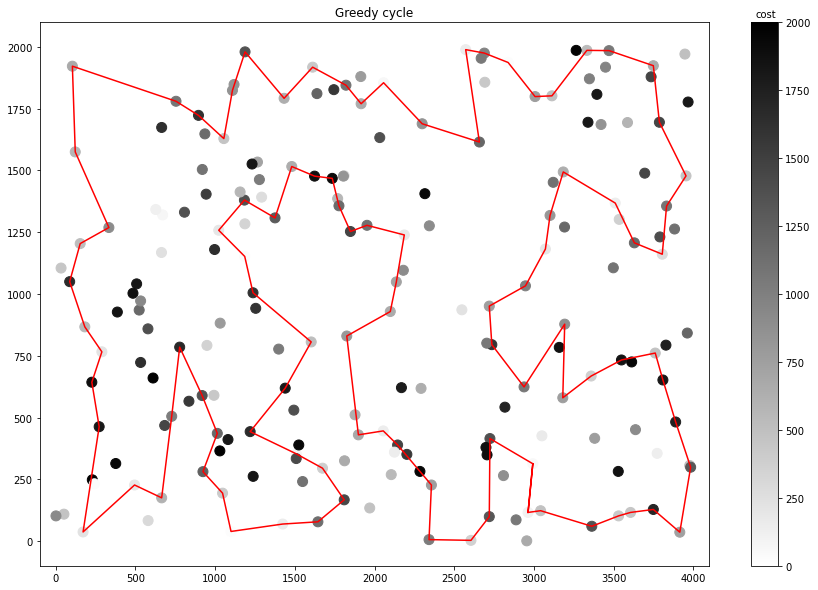

In [111]:
summarize(greedy_cycle, data, 'Greedy cycle',weight=1)

  0%|          | 0/200 [00:00<?, ?it/s]

Greedy cycle:
average score: 172790.965	worst score: 173580.0	best score: 171743.0
Best solution:


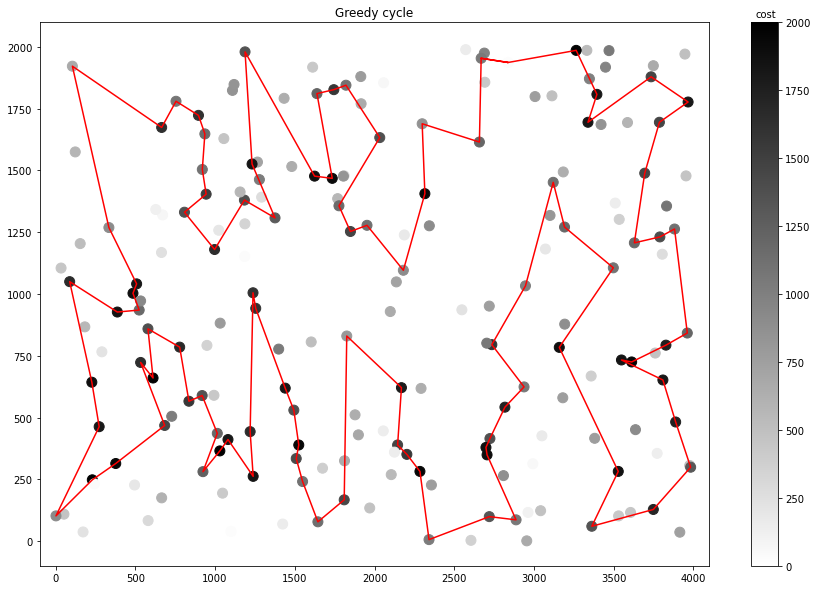

In [112]:
summarize(greedy_cycle, data, 'Greedy cycle',weight=0.5)

In [113]:
data = np.loadtxt('TSPB.csv', dtype=int, delimiter=';')

  0%|          | 0/200 [00:00<?, ?it/s]

Greedy cycle:
average score: 121592.715	worst score: 131138.0	best score: 111115.0
Best solution:


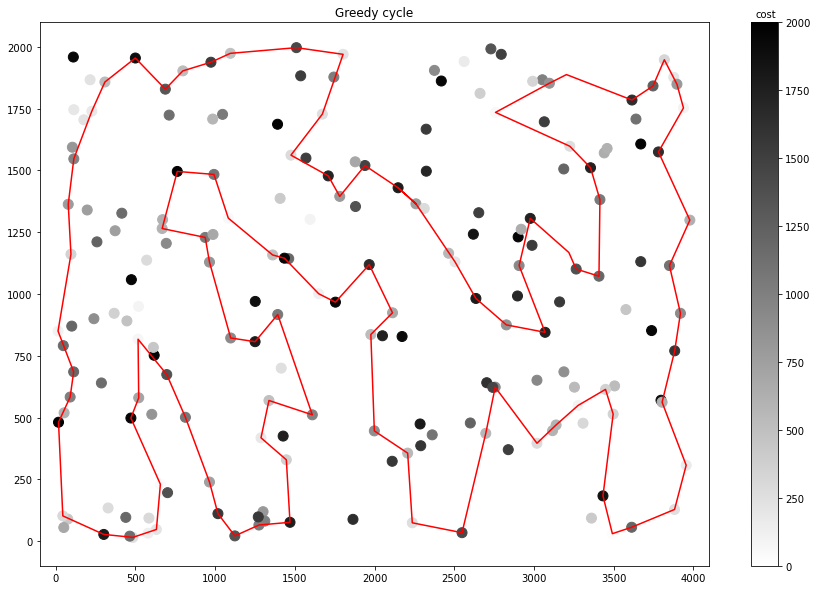

In [114]:
summarize(greedy_cycle, data, 'Greedy cycle',weight=1)

  0%|          | 0/200 [00:00<?, ?it/s]

Greedy cycle:
average score: 171507.865	worst score: 173000.0	best score: 170342.0
Best solution:


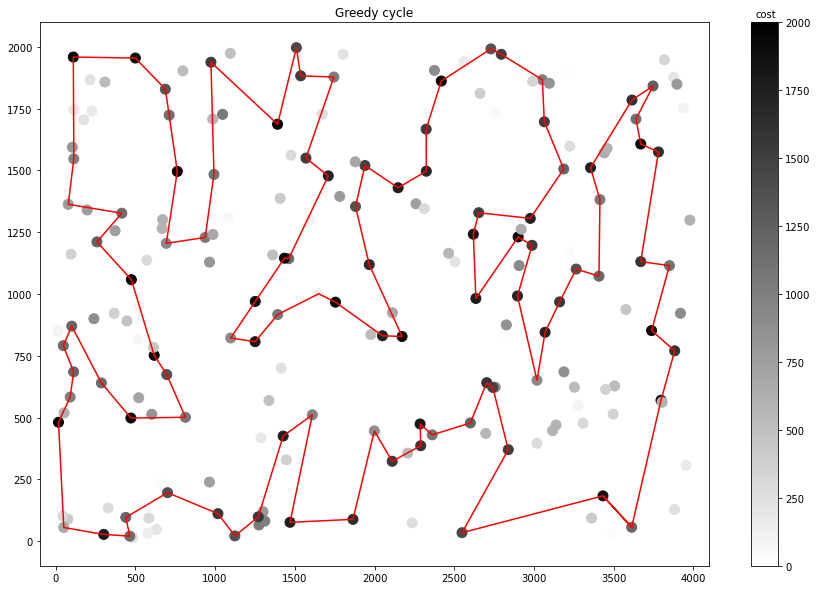

In [115]:
summarize(greedy_cycle, data, 'Greedy cycle',weight=0.5)